# Определение перспективного тарифа для телеком-компании

## Описание проекта
Компания «Мегалайн» — федеральный оператор сотовой связи. Его клиентам предлагают два тарифных плана: «Смарт» и «Ультра». 

Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Описание тарифов
Тариф «Смарт»

- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета: 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 2. сообщение: 3 рубля; 3. 1 Гб интернет-трафика: 200 рублей.

Тариф «Ультра»
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.

Примечание:
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

## Описание данных
Таблица users (информация о пользователях):

- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tarif — название тарифного плана

Таблица calls (информация о звонках):

- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):

- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):

- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):

- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

###  Изучение данных из файлов

In [1]:
import pandas as pd
import numpy as np

calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

In [2]:
import matplotlib.pyplot as plt
from scipy import stats as st

In [3]:
display(calls.head())
print()
calls.info()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [4]:
display(internet.head())
print()
internet.info()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [5]:
display(messages.head())
print()
messages.info()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [6]:
display(tariffs.head())
print()
tariffs.info()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [7]:
display(users.head())
print()
users.info()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


### Подготовка данных

Методом **pd.to_datetime()** переведем значения столбцов с датами в таблицах в объекты **datetime**. Поскольку в таблицах у нас представлен только 2018 год, а для исследования дни недели не имеют значения, оставим только значения месяцев.

In [8]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d').dt.month
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d').dt.month
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d').dt.month
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d').dt.month
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d').dt.month

Поскольку «Мегалайн» всегда округляет секунды до минут, округлим с помощью **np.ceil** значения минут в соответствии с правилами тарифов "Мегалайна" в большую сторону.

In [9]:
calls['duration'] = np.ceil(calls['duration'])

Посчитаем с помощью метода **groupby** для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам

Методы **reset_index** и **colums** используем для устранение многоуровневых названий столбцов.

In [10]:
calls_group = calls.groupby(['user_id', 'call_date']).agg({'duration': {'count', 'sum'}}).sort_values(by=['user_id', 'call_date']).reset_index(col_level = 0)
calls_group.columns = [col[1] if col[1] else col[0] for col in calls_group.columns]
calls_group.columns = ['user_id', 'month', 'call_count', 'call_sum']
calls_group                            

,user_id,month,call_count,call_sum
0,1000,5,22,159.0
1,1000,6,43,172.0
2,1000,7,47,340.0
3,1000,8,52,408.0
4,1000,9,58,466.0
...,...,...,...,...
3169,1498,10,41,247.0
3170,1499,9,9,70.0
3171,1499,10,68,449.0
3172,1499,11,74,612.0


In [11]:
messages_group = messages.groupby(['user_id', 'message_date']).agg({'id': 'count'}).sort_values(by=['user_id', 'message_date']).reset_index()
messages_group.columns = ['user_id', 'month', 'message_sum']
messages_group

,user_id,month,message_sum
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


Oбъем израсходованного интернет-трафика по месяцам также переведем в гигабаты, поскольку в тарифе ведется расчет в этой величине **(1 ГБ = 1024 МБ)**. Сделаем это с помощью **np.ceil** в соответствии с правилами тарифов "Мегалайна" в большую сторону.

In [12]:
internet_group = internet.groupby(['user_id', 'session_date']).agg({'mb_used': 'sum'}).sort_values(by=['user_id', 'session_date']).reset_index()
internet_group['mb_used'] = np.ceil(internet_group['mb_used'] / 1024)
internet_group.columns = ['user_id', 'month', 'gb_used']
internet_group  

,user_id,month,gb_used
0,1000,5,3.0
1,1000,6,23.0
2,1000,7,14.0
3,1000,8,14.0
4,1000,9,15.0
...,...,...,...
3198,1498,10,21.0
3199,1499,9,2.0
3200,1499,10,18.0
3201,1499,11,18.0


Подготовим данные в таблице tariffs - переведем мегабайты в гигабайты на случаи изменения тарифной политики.

In [13]:
tariffs['gb_per_month_included'] = tariffs['mb_per_month_included'] / 1024
tariffs.rename(columns={'tariff_name': 'tariff'}, inplace=True)
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff,gb_per_month_included
0,50,15360,500,550,200,3,3,smart,15.0
1,1000,30720,3000,1950,150,1,1,ultra,30.0


Объединим таблицы в одну методом **merge**

In [14]:
data = calls_group.merge(messages_group, on = ['user_id', 'month'], how = 'outer')
data = data.merge(internet_group, on = ['user_id', 'month'], how = 'outer')
data = data.merge(users, on = ['user_id'], how = 'outer')
data = data.merge(tariffs, on = ['tariff'], how = 'outer')
data = data.fillna(0)

data.head()

,user_id,month,call_count,call_sum,message_sum,gb_used,age,churn_date,city,first_name,...,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included
0,1000,5.0,22.0,159.0,22.0,3.0,52,0.0,Краснодар,Рафаил,...,5,ultra,1000,30720,3000,1950,150,1,1,30.0
1,1000,6.0,43.0,172.0,60.0,23.0,52,0.0,Краснодар,Рафаил,...,5,ultra,1000,30720,3000,1950,150,1,1,30.0
2,1000,7.0,47.0,340.0,75.0,14.0,52,0.0,Краснодар,Рафаил,...,5,ultra,1000,30720,3000,1950,150,1,1,30.0
3,1000,8.0,52.0,408.0,81.0,14.0,52,0.0,Краснодар,Рафаил,...,5,ultra,1000,30720,3000,1950,150,1,1,30.0
4,1000,9.0,58.0,466.0,57.0,15.0,52,0.0,Краснодар,Рафаил,...,5,ultra,1000,30720,3000,1950,150,1,1,30.0


Посчитаем для каждого пользователя помесячную выручку с каждого пользователя. Для этого: 

- вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; 
- остаток умножим на значение из тарифного плана; 
- прибавим абонентскую плату, соответствующую тарифному плану.

In [15]:
def income_counter(row):
    income = row['rub_monthly_fee']
    if row['call_sum'] > row['minutes_included']:
        income+= (row['call_sum'] - row['minutes_included']) * row['rub_per_minute']
    if row['message_sum'] > row['messages_included']:
        income+= (row['message_sum'] - row['messages_included']) * row['rub_per_message']
    if row['gb_used'] > row['gb_per_month_included']:
        income+= (row['gb_used'] - row['gb_per_month_included']) * row['rub_per_gb']
    return income
data['income'] = data.apply(income_counter, axis=1)

In [16]:
data.head()

,user_id,month,call_count,call_sum,message_sum,gb_used,age,churn_date,city,first_name,...,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,income
0,1000,5.0,22.0,159.0,22.0,3.0,52,0.0,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,30.0,1950.0
1,1000,6.0,43.0,172.0,60.0,23.0,52,0.0,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,30.0,1950.0
2,1000,7.0,47.0,340.0,75.0,14.0,52,0.0,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,30.0,1950.0
3,1000,8.0,52.0,408.0,81.0,14.0,52,0.0,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,30.0,1950.0
4,1000,9.0,58.0,466.0,57.0,15.0,52,0.0,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,30.0,1950.0


### Анализ данных

Опишем поведение клиентов оператора, исходя из выборки. 

Для этого посчитаем среднее количество, дисперсию и стандартное отклонение (обозначим их как **_mean, _var, _std** соответственно) для продолжительности разговора, количества сообщений и объёма интернет-трафика для каждого тарифа в месяц. Используемые методы - **groupby(), np.var() и np.sqrt()**

In [17]:
data_ultra = data.query('tariff == "ultra"')
data_smart = data.query('tariff == "smart"')

In [18]:
data_grouped = data.groupby('tariff').agg({'call_sum': 'mean', 'message_sum': 'mean', 'gb_used': 'mean'}).astype('int')
data_grouped.columns = ['call_mean', 'message_mean', 'gb_mean']

data_grouped['call_var'] = [np.var(data_smart['call_sum']), np.var(data_ultra['call_sum'])]
data_grouped['message_var'] = [np.var(data_smart['message_sum']), np.var(data_ultra['message_sum'])]
data_grouped['gb_var'] = [np.var(data_smart['gb_used']), np.var(data_ultra['gb_used'])]

data_grouped['call_std'] = np.sqrt(data_grouped['call_var'])
data_grouped['message_std'] = np.sqrt(data_grouped['message_var'])
data_grouped['gb_std'] = np.sqrt(data_grouped['gb_var'])

data_grouped

,call_mean,message_mean,gb_mean,call_var,message_var,gb_var,call_std,message_std,gb_std
tariff,,,,,,,,,
smart,417,33,16,36265.124153,796.597877,33.118595,190.434041,28.224066,5.754876
ultra,526,49,19,100950.006233,2283.099557,97.279783,317.726307,47.781791,9.863051


Пострим **гистограммы.** Параметр **range** зададим автоатически с помощью расчета интерквартильного размаха.

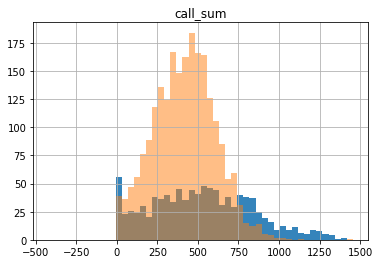

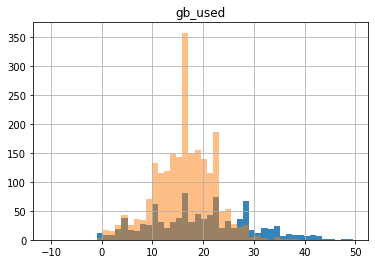

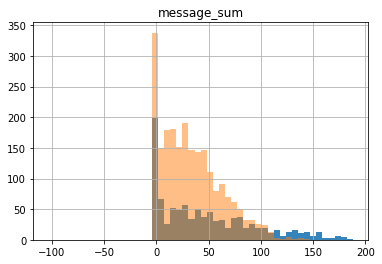

In [19]:
columns_hist = ['call_sum', 'gb_used', 'message_sum']

for i in columns_hist:
    q1 = data_ultra[i].quantile(0.25)
    q3 = data_ultra[i].quantile(0.75)
    iqr = q3 - q1
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    data_ultra[i].hist(bins=50, range = (fence_low, fence_high), alpha=0.9)
    data_smart[i].hist(bins=50, range = (fence_low, fence_high), alpha=0.5)
    plt.title(i)
    plt.show()

Данные по пользователям тарифа **smart** более симметричны, в то время как данные по тарифу **ultra** распределены вправо, то есть имеют больше дополнительных (отличных от средних) положительных значений.

### Проверка гипотез

Проверим гипотезы
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Пороговое значение alpha укажем 0,5.

**Поскольку нулевая гипотеза `p-value < alpha` всегда о том, что различий нет указанные выше гипотезы обозначим как альтернативные. Тогда как нулевые гипотезы сформулируем так:**

**- средняя выручка пользователей тарифов «Ультра» и «Смарт» не различаются;**

**- средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.**

In [24]:
sample_1 = data_smart['income']
sample_2 = data_ultra['income']

alpha = .05 

results = st.ttest_ind(
    sample_1, 
    sample_2)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  8.081909555489933e-161
Отвергаем нулевую гипотезу


**Вывод:** Вероятность получить одинаковое среднее очень мало, поэтому подтверждаем  **альтернативную** гипотезу, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются. Проверим насколько:

In [21]:
display(data_smart['income'].describe())
print('Доход по тарифу smart:', data_smart['income'].sum())

count    2230.000000
mean     1289.641704
std       818.370799
min       550.000000
25%       550.000000
50%      1021.000000
75%      1750.000000
max      6770.000000
Name: income, dtype: float64

Доход по тарифу smart: 2875901.0


In [22]:
display(data_ultra['income'].describe())
print('Доход по тарифу ultra:', data_ultra['income'].sum())

count     986.000000
mean     2070.030426
std       376.015578
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4800.000000
Name: income, dtype: float64

Доход по тарифу ultra: 2041050.0


In [25]:
sample_1 = data.query('city == "Москва"')['income']
sample_2 =  data.query('city != "Москва"')['income']

alpha = .05 

results = st.ttest_ind(
    sample_1, 
    sample_2)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.5400751614511182
Не получилось отвергнуть нулевую гипотезу


**Вывод:** Вероятность получить одинаковое среднее достаточно велико (29 процентов), поэтому **подтверждаем нулевую гипотезу** и отвергаем предположение, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

## Вывод

Среднее использование пользователями тарифа ultra (минут, гигабайт и сообщений) выше, чем у тарифа smart. Вместе с тем, для оператора тариф smart более прибыльный (общий доход 2597684 против 2041050 на ultra), поскольку он более популярен. Однако тариф ultra позволяет охватить пользователей, которые готовы больше пользоваться услугами оператора и имеют больший средний чек. Гипотеза о том, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов в ходе исследования не подтвердилась.
 
 